#  Прогнозирование заказов такси

Предоставлены исторические данные о заказах такси в аэропортах. Необходимо построить модель для прогнозирования количества заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [2]:
import pprint

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

import lightgbm as lgb

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

import optuna

In [3]:
RANDOM_STATE = 42

In [4]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
data = data.sort_index().resample('1H').sum()

In [6]:
data.sample(5)

,num_orders
datetime,
2018-07-11 09:00:00,104
2018-06-10 22:00:00,66
2018-08-20 20:00:00,77
2018-08-29 13:00:00,135
2018-07-02 23:00:00,121


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
data.index.is_monotonic

<ipython-input-8-888b7429bc83>:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  data.index.is_monotonic


True

In [9]:
data.isna().sum()

num_orders    0
dtype: int64

In [10]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Вывод**:

1. Выполнили ресемплирование по одному часу.
2. Порядок дат соблюден.
3. Данные без пропусков.
4. Аномальные значения отсутствуют.

## Анализ

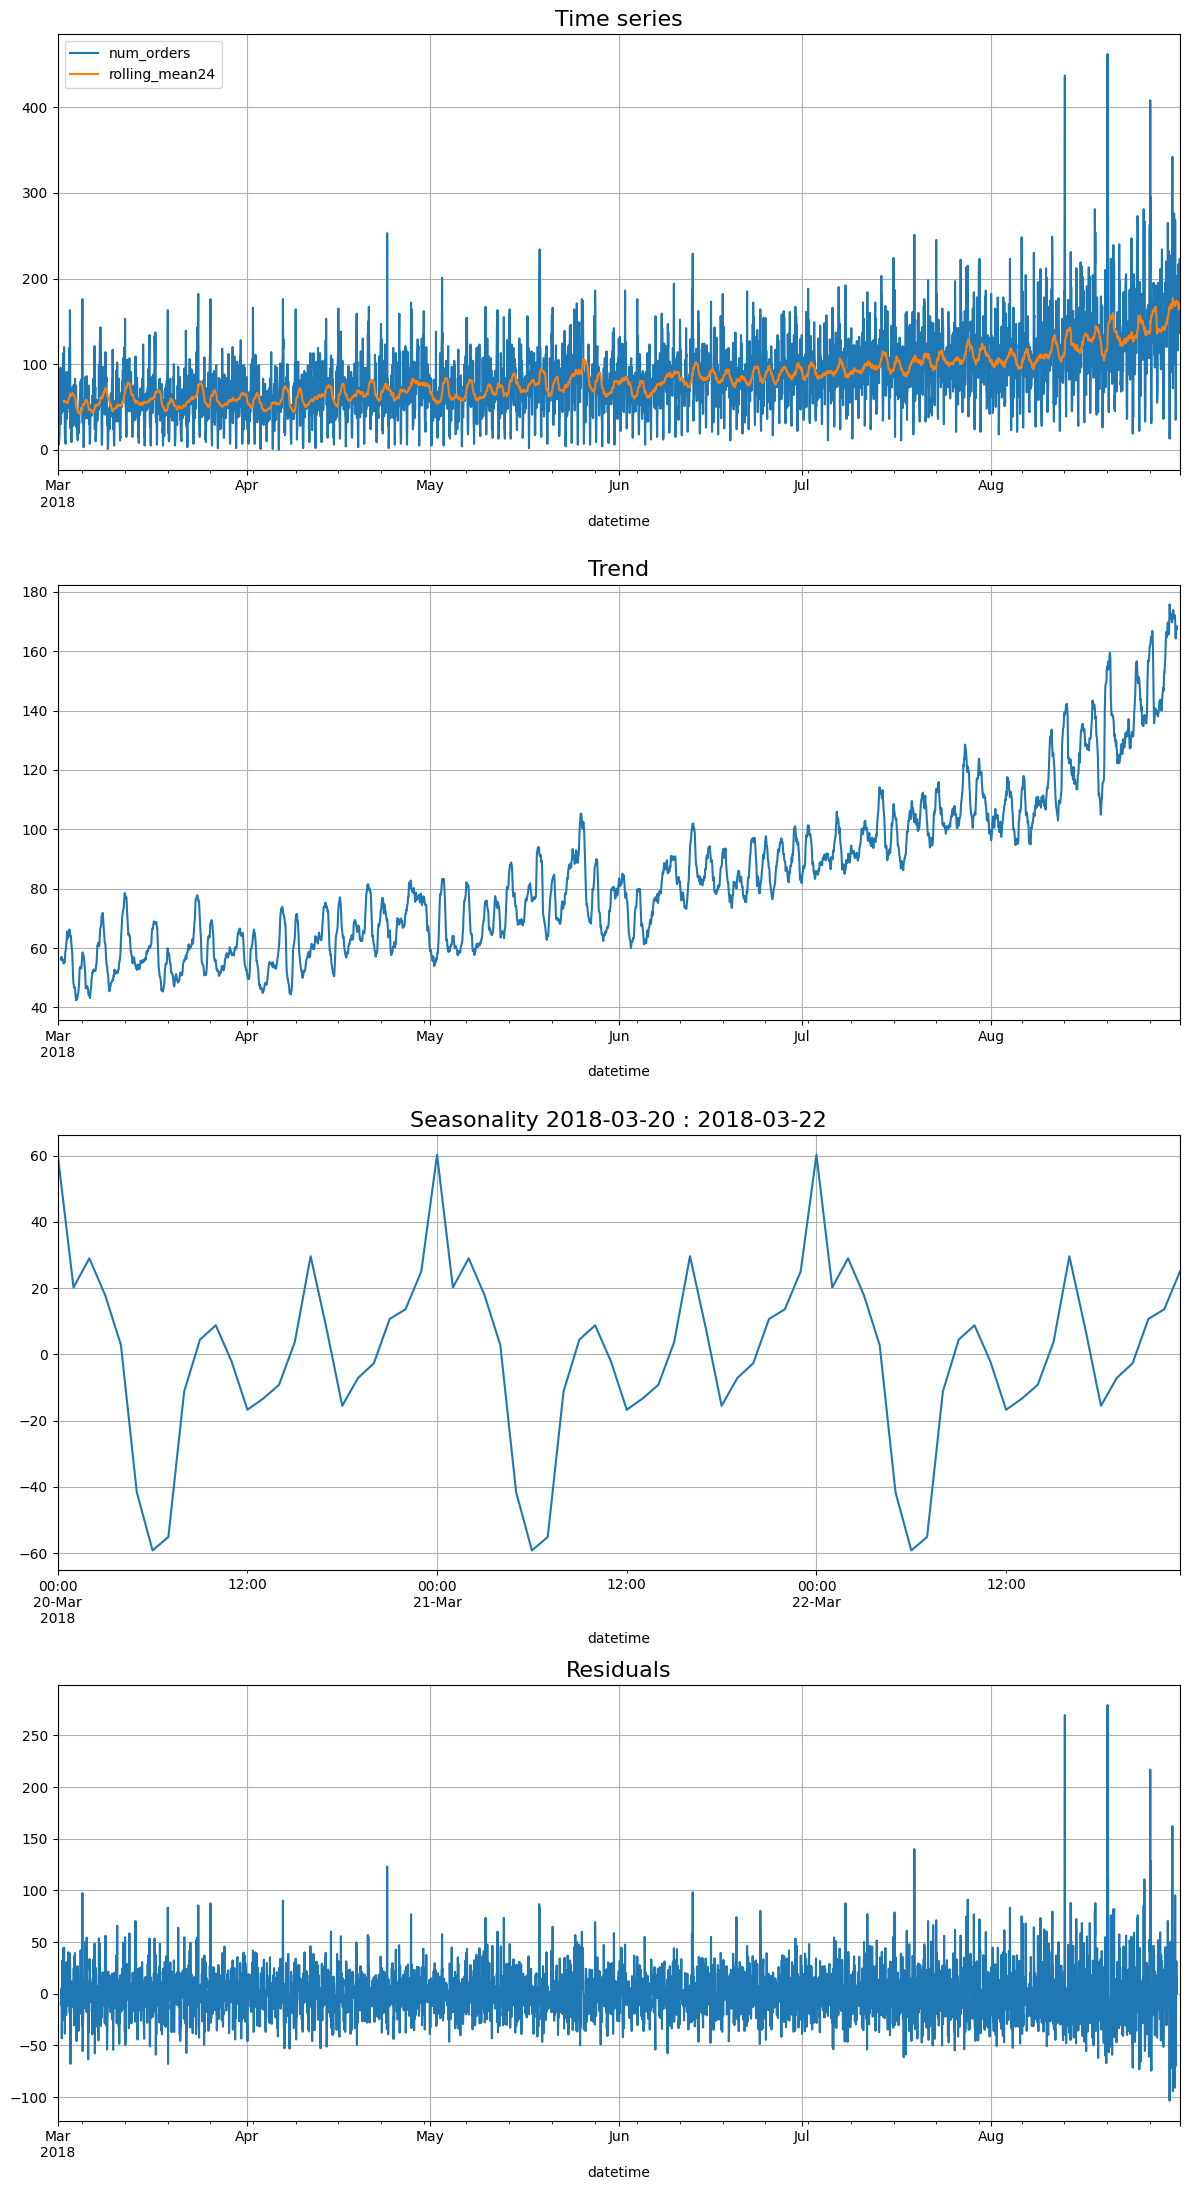

In [11]:
data['rolling_mean24'] = data.rolling(24, closed='left').mean()
decomposed = seasonal_decompose(data.drop('rolling_mean24', axis=1))

fig, axs = plt.subplots(4, 1, figsize=(12, 22))

data.plot(ax=axs[0], grid=True)
axs[0].set_title('Time series', fontsize=16)

decomposed.trend.plot(ax=axs[1], grid=True)
axs[1].set_title('Trend', fontsize=16)

decomposed.seasonal['2018-03-20':'2018-03-22'].plot(ax=axs[2], grid=True)
axs[2].set_title('Seasonality 2018-03-20 : 2018-03-22', fontsize=16)

decomposed.resid.plot(ax=axs[3], grid=True)
axs[3].set_title('Residuals', fontsize=16)

plt.tight_layout()
plt.show()

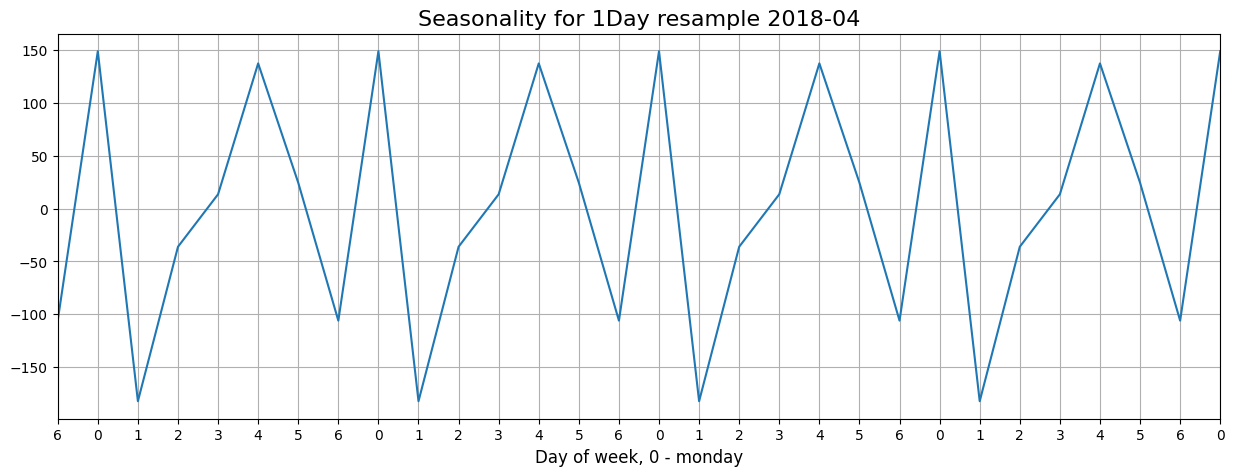

In [12]:
data_1d = data.drop('rolling_mean24', axis=1).resample('1D').sum()
decomposed_1 = seasonal_decompose(data_1d)

decomposed_1.seasonal['2018-04'].plot(figsize=(15, 5), grid=True)
plt.xticks(data_1d.loc['2018-04'].index, labels=data_1d.loc['2018-04'].index.dayofweek)
plt.title('Seasonality for 1Day resample 2018-04', fontsize=16)
plt.xlabel('Day of week, 0 - monday', fontsize=12)
plt.show()

**Вывод**:

1. Среднее количество заказов такси в аэропортах в час с марта 2018 года по август выросло примерно в 3 раза.
   
   *Возможно, это связано с увеличением количества перелетов, которые в свою очередь увеличились за счет отпусков в летнее время.*
   
   
2. Период сезонности равен примерно суткам и количество заказов в час растет в среднем около 9 часов утра, 6 часов вечера и в полночь (больше всего).
   
   *Это может быть связано с временными промежутками, в которых люди больше передвигаются: утро, вечер, а также много перелетов происходит около полуночи.*
   

3. Если ресемплировать ряд по дню, то можно заметить также и недельную сезонность. Количество заказов растет в понедельник и пятницу.

## Обучение

In [13]:
# delete useless col
data = data.drop('rolling_mean24', axis=1)

**Функция для добавления новых признаков (сдвиги целевой переменной, скользящее среднее, даты и время)**

In [14]:
def make_features(data, lags, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in lags:
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size, closed='left').mean()

**Построим график автокорреляционной функции для выбора количества сдвигов**

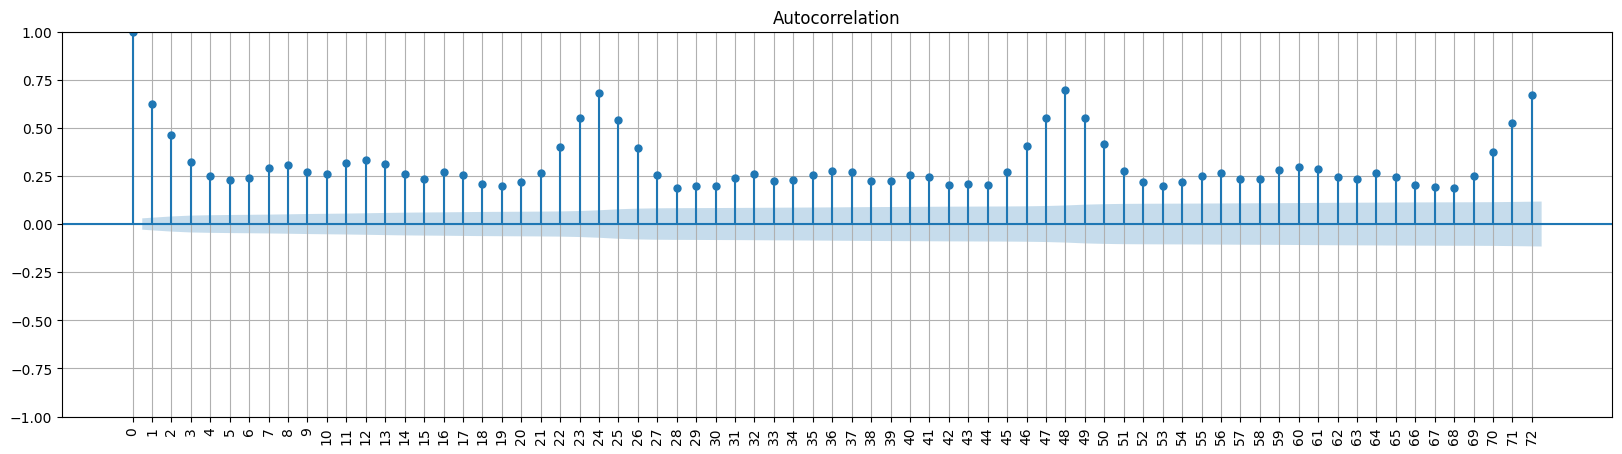

In [15]:
plt.figure(figsize=(20, 5))
plot_acf(data.values.squeeze(), lags=72, ax=plt.gca())
plt.xticks(range(73), rotation=90)
plt.grid()
plt.show()

**Добавим в признаки 1, 2, 24, 48, 72 сдвиги и выберем окно для скользящего среднего в 12 часов**

**Разделим на обучающую и тестовую выборки и отделим целевой признак**

In [16]:
data_copy = data.copy()
make_features(data_copy, [1, 2, 24, 48, 72], 12)
data_copy[['hour', 'dayofweek']] = data_copy[['hour', 'dayofweek']].astype('category')

train, test = train_test_split(data_copy, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

### RidgeCV

**Генератор фолдов для кросс-валидации временных рядов**

In [17]:
cv = TimeSeriesSplit(test_size=X_train.shape[0]//50).split(X_train)

In [18]:
# lists of num and cat feature names
numerical_features = X_train.select_dtypes('number').columns
categorical_features = X_train.select_dtypes('category').columns

# create transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# define ridge model
ridge = RidgeCV(alphas=np.logspace(-3, 1, 20),
                scoring='neg_root_mean_squared_error',
                cv=cv,
               )

# combine scaler and ohe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

# combine preprocessing and model
ridge_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', ridge),
    ]
)

In [19]:
ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['lag_1', 'lag_2', 'lag_24', 'lag_48', 'lag_72', 'rolling_mean'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['hour', 'dayofweek'], dtype='object'))])),
                ('model',
                 RidgeCV(alphas=array([1.00000000e-03, 1.62377...3240e-03,
       6.95192796e-03, 1.12883789e-02, 1.83298071e-02, 2.97635144e-02,
       4.83293024e-02, 7.84759970e-02, 1.27427499e-01, 2.06913808e-01,
       3.35981829e-01, 5.45559478e-01, 8.85866790e-01, 1.43844989e+00,
       2.33572147e+00, 3.79269019e+00, 6.15848211e+00, 1.00000000e+01]),
                         cv=<generator object TimeSeriesSplit.split at 0x7edd683a2570>,
                         scoring='neg_root_mean_squared_error'))])

In [20]:
print(f'Ridge rmse: {-ridge_pipeline["model"].best_score_}\n'
      f'Ridge alpha: {ridge_pipeline["model"].alpha_}'
)

Ridge rmse: 29.436530220167175
Ridge alpha: 0.8858667904100823


### LightGBMRegressor

**Для подбора гиперпараметров воспользуемся средствами библиотеки `optuna`**

In [21]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': RANDOM_STATE,
        'n_estimators': 1000,
        'verbosity': -1,
        'bagging_freq': 1,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'max_bin': trial.suggest_int('max_bin', 256, 1024)
    }
    cv = TimeSeriesSplit(test_size=X_train.shape[0]//50).split(X_train)
    model = lgb.LGBMRegressor(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error',)
    return -scores.mean()

In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-12-24 00:54:14,218] A new study created in memory with name: no-name-5318b6d5-bf76-4814-a0a3-66abd541563f
[I 2023-12-24 00:54:16,041] Trial 0 finished with value: 28.059365550041356 and parameters: {'learning_rate': 0.09295201070370579, 'num_leaves': 553, 'subsample': 0.3045669009721367, 'colsample_bytree': 0.5933073955498697, 'min_data_in_leaf': 74, 'max_bin': 956}. Best is trial 0 with value: 28.059365550041356.
[I 2023-12-24 00:54:19,353] Trial 1 finished with value: 30.288836677739795 and parameters: {'learning_rate': 0.00795825858663006, 'num_leaves': 425, 'subsample': 0.08145311056830362, 'colsample_bytree': 0.2349127964239957, 'min_data_in_leaf': 6, 'max_bin': 419}. Best is trial 0 with value: 28.059365550041356.
[I 2023-12-24 00:54:22,586] Trial 2 finished with value: 27.426259262248387 and parameters: {'learning_rate': 0.012618677049268834, 'num_leaves': 44, 'subsample': 0.6616443825154811, 'colsample_bytree': 0.8672655930153799, 'min_data_in_leaf': 74, 'max_bin': 376}

In [23]:
print('Best RMSE: ', study.best_value)
print('Best hyperparams:')
study.best_params

Best RMSE:  27.004859644464467
Best hyperparams:


{'learning_rate': 0.023503479897192796,
 'num_leaves': 10,
 'subsample': 0.8146651707797327,
 'colsample_bytree': 0.9651861690338105,
 'min_data_in_leaf': 54,
 'max_bin': 276}

In [24]:
best_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': RANDOM_STATE,
        'n_estimators': 1000,
        'verbosity': -1,
        'bagging_freq': 1,
}
best_params.update(study.best_params)

In [25]:
model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train)

LGBMRegressor(bagging_freq=1, colsample_bytree=0.9651861690338105,
              learning_rate=0.023503479897192796, max_bin=276, metric='rmse',
              min_data_in_leaf=54, n_estimators=1000, num_leaves=10,
              objective='regression', random_state=42,
              subsample=0.8146651707797327, verbosity=-1)

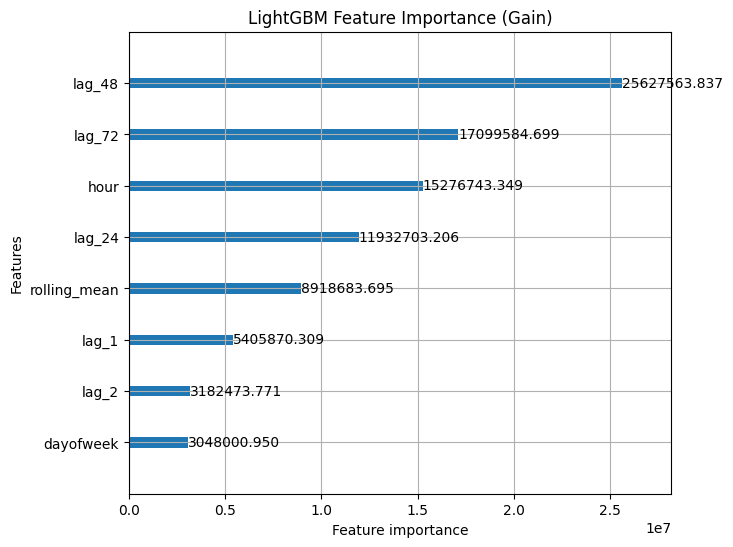

In [26]:
# plot feature importance using Gain
lgb.plot_importance(model, importance_type='gain', figsize=(7,6), title='LightGBM Feature Importance (Gain)')
plt.show()

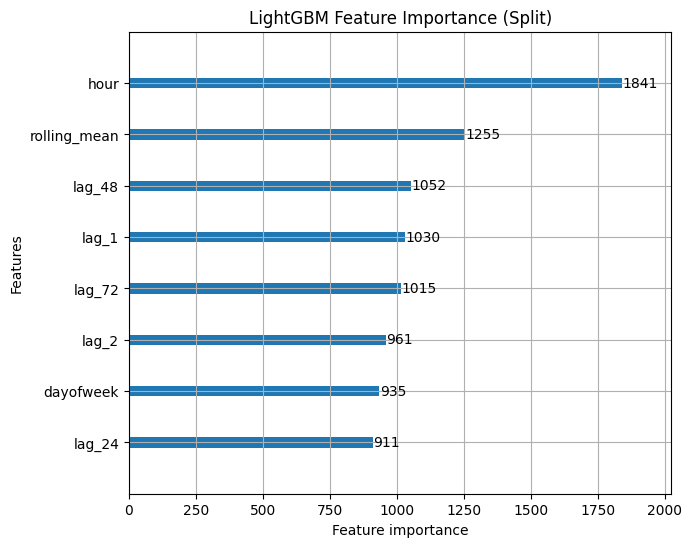

In [27]:
# plot feature importance using Split
lgb.plot_importance(model, importance_type='split', figsize=(7,6), title='LightGBM Feature Importance (Split)')
plt.show()

**Вывод**:

Лучше себя показал LGBMRegressor с RMSE = 27.005. Тестирование будем проводить на этой модели.

## Тестирование

In [28]:
pred = model.predict(X_test)
print('RMSE:', mean_squared_error(y_test, pred, squared=False))

RMSE: 37.48404616589057


Сравним результат с моделью, прогнозирующей новое значение по предыдущему.

In [29]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]

print('RMSE:', mean_squared_error(y_test, pred_previous, squared=False))

RMSE: 58.856486242815066


## Вывод

При подготовке:    
   1. Данные были ресемплированы по одному часу.
   2. Пропуски отсутствовали.
   3. Аномальные значения отсутствали.

В резульате анализа выявлено:
   1. Среднее количество заказов такси в аэропортах в час с марта 2018 года по август выросло примерно в 3 раза.
      
      *Возможно, это связано с увеличением количества перелетов, которые в свою очередь увеличились за счет отпусков в летнее время.*


   2. Период сезонности равен примерно суткам и количество заказов в час растет в среднем около 9 часов утра, 6 часов вечера и в полночь (больше всего).

      *Это может быть связано с временными промежутками, в которых люди больше передвигаются: утро, вечер, а также много перелетов происходит около полуночи.*
      

   3. Если ресемплировать ряд по дню, то можно заметить также и недельную сезонность. Количество заказов растет в понедельник и пятницу.

После обучения и сравнения была выбрана модель LGBMRegressor. В ходе тестирования было получено значение RMSE = 37.48. Требования соблюдены.